In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys

# Project Imports
from notebooks.consts import *
from notebooks.preprocessing import preprocess_aso_data, get_unique_genes
from tauso.genome.read_human_genome import get_locus_to_data_dict
from tauso.data.data import get_paths

# Refactored Modules for Genomic Mapping
from tauso.genome.TranscriptMapper import GeneCoordinateMapper, build_gene_sequence_registry
from tauso.algorithms.genomic_context_windows import add_external_mrna_and_context_columns

# Feature Extraction Imports (Refactored from generate_seq_features)
from Bio.SeqUtils import gc_fraction
from tauso.features.seq_features import (
    purine_content, count_g_runs, compute_ENC, palindromic_fraction,
    seq_entropy, hairpin_score, toxic_motif_count, hairpin_dG_energy,
    hairpin_tm, tandem_repeats_score, dispersed_repeats_score,
    flexible_dinucleotide_fraction, gc_skew, gc_skew_ends, at_skew,
    stop_codon_count, nucleotide_diversity, cg_dinucleotide_fraction,
    poly_pyrimidine_stretch, dinucleotide_entropy, gc_block_length,
    at_rich_region_score, gc_content_3prime_end, homooligo_count
)
# Pandas Display Settings
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 2000)
pd.set_option('display.max_columns', None)

In [2]:
# Load and preprocess the dataset
# This handles: Filtering Human, Dropping NaNs, Log Correction, and standardizing columns
all_data = preprocess_aso_data(UPDATED_CSV, include_smiles=False)

print(f"Data ready. Shape: {all_data.shape}")

Preprocessing complete. Final valid rows: 29987
Data ready. Shape: (29987, 29)


Preprocessing ASO Experimental Dataset

Generate features

In [3]:
# A. Identify unique target genes in the dataset
target_genes = get_unique_genes(all_data)

# B. Initialize the Coordinate Mapper with the GRCh38 database
paths = get_paths('GRCh38')
mapper = GeneCoordinateMapper(paths['db'])

# C. Fetch the raw genomic data for the subset of experimental genes
gene_to_data = get_locus_to_data_dict(include_introns=False, gene_subset=target_genes)

# D. Build the Registry object
# This maps genes to their CDS and other metadata required for context mapping
ref_registry = build_gene_sequence_registry(
    genes=target_genes,
    gene_to_data=gene_to_data,
    mapper=mapper
)

print(f"Registry built for {len(ref_registry)} experimental genes.")

Elapsed DB:  0.00051116943359375
Elapsed Fasta:  0.00051116943359375
Length:  3267117988
Registry built for 15 experimental genes.


In [4]:
# Define window sizes for context extraction
FLANK_SIZES_PREMRNA = [20, 30, 40, 50, 60, 70]
CDS_WINDOWS = [20, 30, 40, 50, 60, 70]

# Run the optimized context generator
# This adds columns like 'sense_sequence', 'flank_sequence_X', etc.
df_with_features = add_external_mrna_and_context_columns(
    df=all_data,
    mapper=mapper,
    gene_registry=ref_registry,
    flank_sizes_premrna=FLANK_SIZES_PREMRNA,
    flank_sizes_cds=CDS_WINDOWS
)

print("Genomic context added.")

Genomic context added.


In [5]:
import time
from pandarallel import pandarallel

# Initialize pandarallel
# progress_bar=False prevents it from cluttering the output since we are adding our own custom logging
pandarallel.initialize(progress_bar=True, verbose=0)

def calc_feature(df, col_name, func, input_col='Sequence'):
    """
    Computes a feature in parallel with a visible progress bar and timing logs.
    """
    print(f"► Starting {col_name}...")
    start_time = time.time()

    # parallel_apply will now show a progress bar (tqdm style) due to initialization settings
    df[col_name] = df[input_col].parallel_apply(func)

    duration = time.time() - start_time
    print(f"✔ Finished {col_name} | Time: {duration:.2f}s\n")
print("Calculating Sequence Features...")

# 1. Basic Composition Features
calc_feature(df_with_features, 'Sequence_purine_content', purine_content)
calc_feature(df_with_features, 'Sequence_gc_content', gc_fraction)
calc_feature(df_with_features, 'Sequence_ggg_counts', count_g_runs)
calc_feature(df_with_features, 'Sequence_ENC', compute_ENC)

# 2. Palindromes and Entropy
calc_feature(df_with_features, 'Sequence_4_palindromic', lambda x: palindromic_fraction(x, 4))
calc_feature(df_with_features, 'Sequence_6_palindromic', lambda x: palindromic_fraction(x, 6))
calc_feature(df_with_features, 'Sequence_entropy', seq_entropy)
calc_feature(df_with_features, 'Sequence_dinucleotide_entropy', dinucleotide_entropy)
calc_feature(df_with_features, 'Sequence_nucleotide_diversity', nucleotide_diversity)

# 3. Structure and Energy (Hairpins/Motifs)
calc_feature(df_with_features, 'Sequence_hairpin_score', hairpin_score)
calc_feature(df_with_features, 'Sequence_hairpin_dG_energy', hairpin_dG_energy)
calc_feature(df_with_features, 'Sequence_hairpin_tm', hairpin_tm)
calc_feature(df_with_features, 'Sequence_toxic_motif_count', toxic_motif_count)

# 4. Repeats and Skews
calc_feature(df_with_features, 'Sequence_tandem_repeats_score', tandem_repeats_score)
calc_feature(df_with_features, 'Sequence_dispersed_repeats_score', dispersed_repeats_score)
calc_feature(df_with_features, 'Sequence_gc_skew', gc_skew)
calc_feature(df_with_features, 'Sequence_gc_skew_ends', gc_skew_ends)
calc_feature(df_with_features, 'Sequence_at_skew', at_skew)

# 5. Advanced Region Scores
calc_feature(df_with_features, 'Sequence_flexible_dinucleotide_fraction', flexible_dinucleotide_fraction)
calc_feature(df_with_features, 'Sequence_stop_codon_count', stop_codon_count)
calc_feature(df_with_features, 'Sequence_cg_dinucleotide_fraction', cg_dinucleotide_fraction)
calc_feature(df_with_features, 'Sequence_poly_pyrimidine_stretch', poly_pyrimidine_stretch)
calc_feature(df_with_features, 'Sequence_gc_block_length', gc_block_length)
calc_feature(df_with_features, 'Sequence_at_rich_region_score', at_rich_region_score)
calc_feature(df_with_features, 'Sequence_gc_content_3prime_end', gc_content_3prime_end)
calc_feature(df_with_features, 'Sequence_homooligo_count', homooligo_count)

print("Basic Sequence Features Calculation Complete.")

Calculating Sequence Features...
► Starting Sequence_purine_content...


✔ Finished Sequence_purine_content | Time: 0.32s

► Starting Sequence_gc_content...


✔ Finished Sequence_gc_content | Time: 0.18s

► Starting Sequence_ggg_counts...


✔ Finished Sequence_ggg_counts | Time: 0.20s

► Starting Sequence_ENC...


✔ Finished Sequence_ENC | Time: 16.88s

► Starting Sequence_4_palindromic...


✔ Finished Sequence_4_palindromic | Time: 1.00s

► Starting Sequence_6_palindromic...


✔ Finished Sequence_6_palindromic | Time: 1.01s

► Starting Sequence_entropy...


✔ Finished Sequence_entropy | Time: 0.42s

► Starting Sequence_dinucleotide_entropy...


✔ Finished Sequence_dinucleotide_entropy | Time: 0.89s

► Starting Sequence_nucleotide_diversity...


✔ Finished Sequence_nucleotide_diversity | Time: 0.21s

► Starting Sequence_hairpin_score...


✔ Finished Sequence_hairpin_score | Time: 0.24s

► Starting Sequence_hairpin_dG_energy...


✔ Finished Sequence_hairpin_dG_energy | Time: 0.29s

► Starting Sequence_hairpin_tm...


✔ Finished Sequence_hairpin_tm | Time: 0.32s

► Starting Sequence_toxic_motif_count...


✔ Finished Sequence_toxic_motif_count | Time: 0.23s

► Starting Sequence_tandem_repeats_score...


✔ Finished Sequence_tandem_repeats_score | Time: 0.26s

► Starting Sequence_dispersed_repeats_score...


✔ Finished Sequence_dispersed_repeats_score | Time: 0.26s

► Starting Sequence_gc_skew...


✔ Finished Sequence_gc_skew | Time: 0.20s

► Starting Sequence_gc_skew_ends...


✔ Finished Sequence_gc_skew_ends | Time: 1.97s

► Starting Sequence_at_skew...


✔ Finished Sequence_at_skew | Time: 1.69s

► Starting Sequence_flexible_dinucleotide_fraction...


✔ Finished Sequence_flexible_dinucleotide_fraction | Time: 0.20s

► Starting Sequence_stop_codon_count...


✔ Finished Sequence_stop_codon_count | Time: 0.28s

► Starting Sequence_cg_dinucleotide_fraction...


✔ Finished Sequence_cg_dinucleotide_fraction | Time: 0.20s

► Starting Sequence_poly_pyrimidine_stretch...


✔ Finished Sequence_poly_pyrimidine_stretch | Time: 0.24s

► Starting Sequence_gc_block_length...


✔ Finished Sequence_gc_block_length | Time: 0.21s

► Starting Sequence_at_rich_region_score...


✔ Finished Sequence_at_rich_region_score | Time: 0.28s

► Starting Sequence_gc_content_3prime_end...


✔ Finished Sequence_gc_content_3prime_end | Time: 0.25s

► Starting Sequence_homooligo_count...


✔ Finished Sequence_homooligo_count | Time: 0.74s

Basic Sequence Features Calculation Complete.


In [10]:
from notebooks.utils.correlation_test import analyze_feature_correlations

# Define the list of features we just generated for filtering the result view
seq_feature_list = [
    'Sequence_purine_content', 'Sequence_gc_content', 'Sequence_ggg_counts', 'Sequence_ENC',
    'Sequence_4_palindromic', 'Sequence_6_palindromic', 'Sequence_entropy', 'Sequence_hairpin_score',
    'Sequence_toxic_motif_count', 'Sequence_hairpin_dG_energy', 'Sequence_hairpin_tm',
    'Sequence_tandem_repeats_score', 'Sequence_dispersed_repeats_score',
    'Sequence_flexible_dinucleotide_fraction', 'Sequence_gc_skew', 'Sequence_gc_skew_ends',
    'Sequence_at_skew', 'Sequence_stop_codon_count', 'Sequence_nucleotide_diversity',
    'Sequence_cg_dinucleotide_fraction', 'Sequence_poly_pyrimidine_stretch',
    'Sequence_dinucleotide_entropy', 'Sequence_gc_block_length', 'Sequence_at_rich_region_score',
    'Sequence_gc_content_3prime_end', 'Sequence_homooligo_count'
]

# Analyze Correlations
results_df = analyze_feature_correlations(df_with_features, target='log_inhibition')

# Display the subset of results relevant to this notebook
print("Correlation Results for Sequence Features:")
display(results_df[results_df['Feature'].isin(seq_feature_list)])

Correlation Results for Sequence Features:


,Feature,Pearson,Spearman,NMI_max
53,Sequence_entropy,0.028,0.040,0.025
50,Sequence_ENC,0.009,0.019,0.024
48,Sequence_gc_content,-0.048,-0.044,0.022
54,Sequence_dinucleotide_entropy,0.063,0.076,0.020
58,Sequence_hairpin_tm,-0.017,-0.034,0.018
60,Sequence_tandem_repeats_score,-0.035,-0.040,0.017
61,Sequence_dispersed_repeats_score,0.021,0.032,0.017
57,Sequence_hairpin_dG_energy,0.031,0.021,0.016
47,Sequence_purine_content,-0.043,-0.043,0.016
65,Sequence_flexible_dinucleotide_fraction,0.005,0.012,0.015


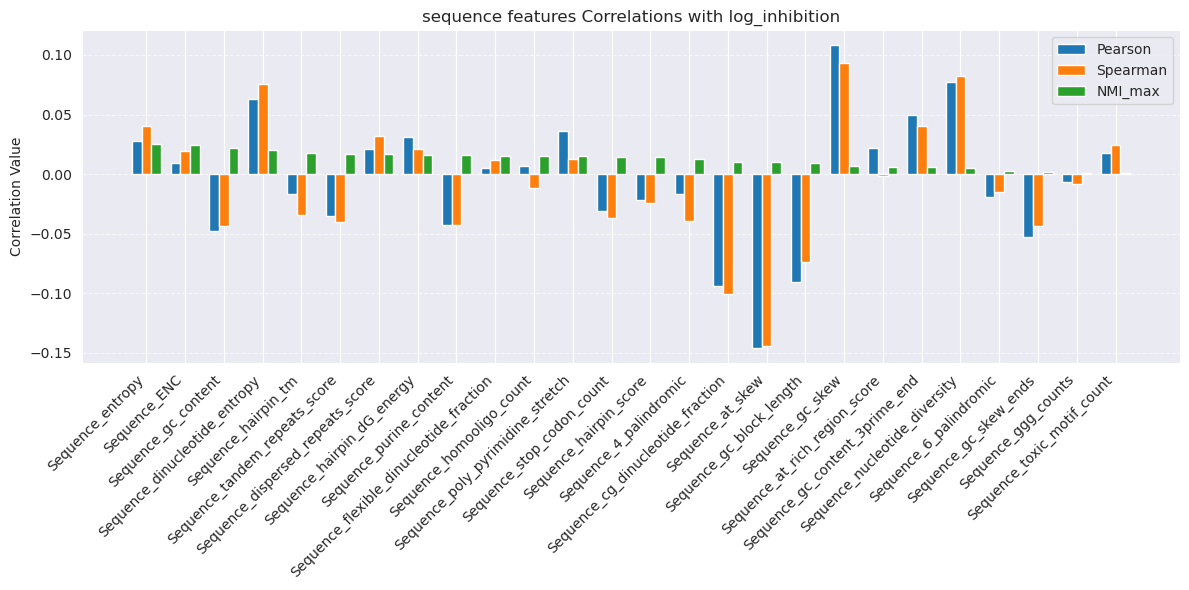

In [11]:
from notebooks.utils.correlation_test import plot_feature_correlations_by_prefix
plot_feature_correlations_by_prefix(results_df, prefix='Sequence_', title='sequence features Correlations with log_inhibition')

In [12]:
from notebooks.features.feature_extraction import save_feature
for feature in seq_feature_list:
    save_feature(df_with_features, feature_name=feature)